In [24]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [25]:
session = fastf1.get_session(2023,12,4)
session.load()


core           INFO 	Loading data for Belgian Grand Prix - Sprint [v2.3.1]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([

### Pre defined

In [26]:
compound_color = {'HARD': 'F0F0EC', 
                  'INTERMEDIATE': '43B02A', 
                  'MEDIUM': 'FFD12E', 
                  'SOFT': 'DA291C', 
                  'TEST-UNKNOWN': '434649', 
                  'UNKNOWN': '00FFFF', 
                  'WET': '0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']

In [27]:
def max_lap(laps):
    grouped = laps.groupby("Driver")
    count_values = grouped['LapNumber'].count()
    return count_values.max()

In [28]:
laps = session.laps.pick_quicklaps()
max_lap = int(max_lap(laps)+1)
max_lap_time = int(session.laps["LapTime"].dt.total_seconds().max())
drivers = session.drivers
comp = 0

In [29]:
laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")

C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\526366515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\526366515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")


### Qualifing

### Top Speed Qualifing 

In [30]:
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []
df_top_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        Top_Speed = max_speed.loc[max_speed['Speed'].idxmax(),"Speed"]
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = session.get_driver(i)[["TeamColor"]].values[0]
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        top_speed_list.append(Top_Speed)
        color_list.append('#'+TeamColor)
df_top_speed["DriverNumber"] = driver_list
df_top_speed["Driver"] = DriverAB_list
df_top_speed["TopSpeed"] = top_speed_list
df_top_speed["Color"] = color_list
df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False)

c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

The DataFrame is empty


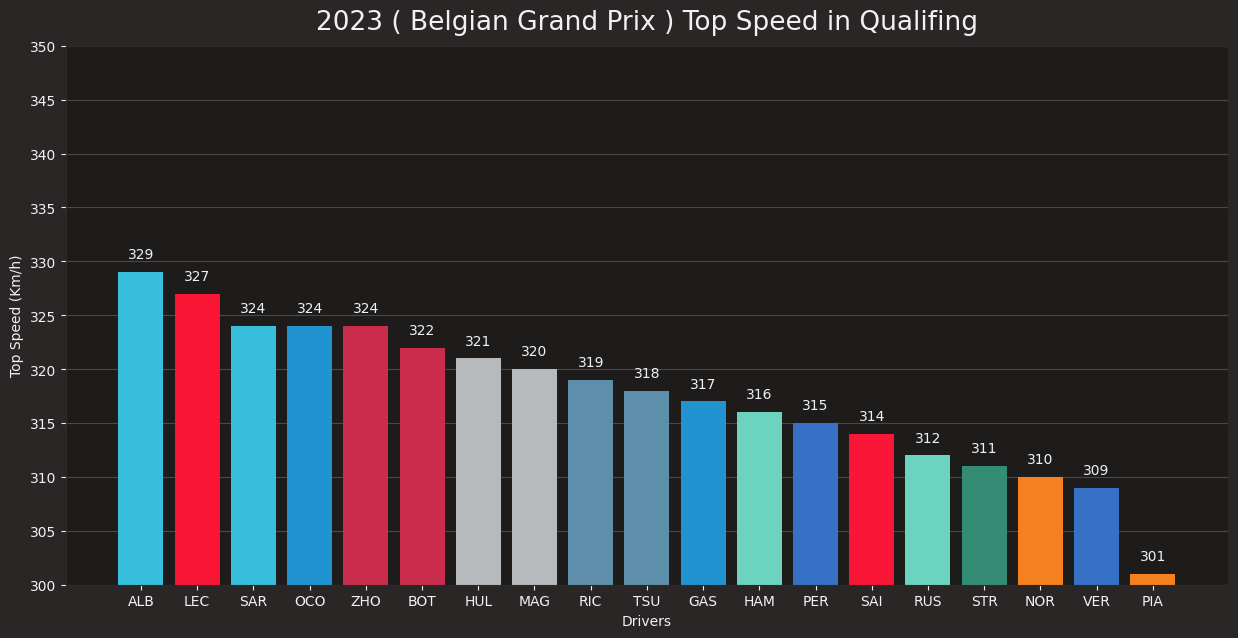

In [31]:
plt.figure(figsize=(15, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Top Speed in Qualifing')
plt.yticks(range(300, 400, 5))
plt.ylim(300, 350)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+1, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y',alpha = 0.2)

# Display the plot
plt.show()

### Lap time Qualifing

In [32]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [33]:
comp = 0
laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")

C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\145889961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\145889961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")


In [34]:
laps["LapTimeS"] = laps["LapTime"].dt.total_seconds()
laps["LapTimeS"] = laps["LapTimeS"] - 60

C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\3527818508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeS"] = laps["LapTime"].dt.total_seconds()
C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\3527818508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeS"] = laps["LapTimeS"] - 60


In [35]:
if(comp == 0):
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]]
    laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
    laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
    laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
    laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

else:
    laps_session = laps.loc[(laps["Compound"] == compound[comp]),["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]]
    laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
    laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
    laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
    laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\3350552484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\3350552484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
C:\Users\GTR\AppData\Local\Temp\ipykernel_2964\3350552484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [36]:
# if(comp == 0):
#     laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]]
#     laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
#     laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.minute
# else:
#     laps_session = laps.loc[(laps["Compound"] == compound[comp]),["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]]
#     laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
#     laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.minute

In [37]:
max_lap_time = int(laps_session["LapTimeS"].max()+1)
min_lap_time = int(laps_session["LapTimeS"].min()-1)

### Graph Pace Qualifing

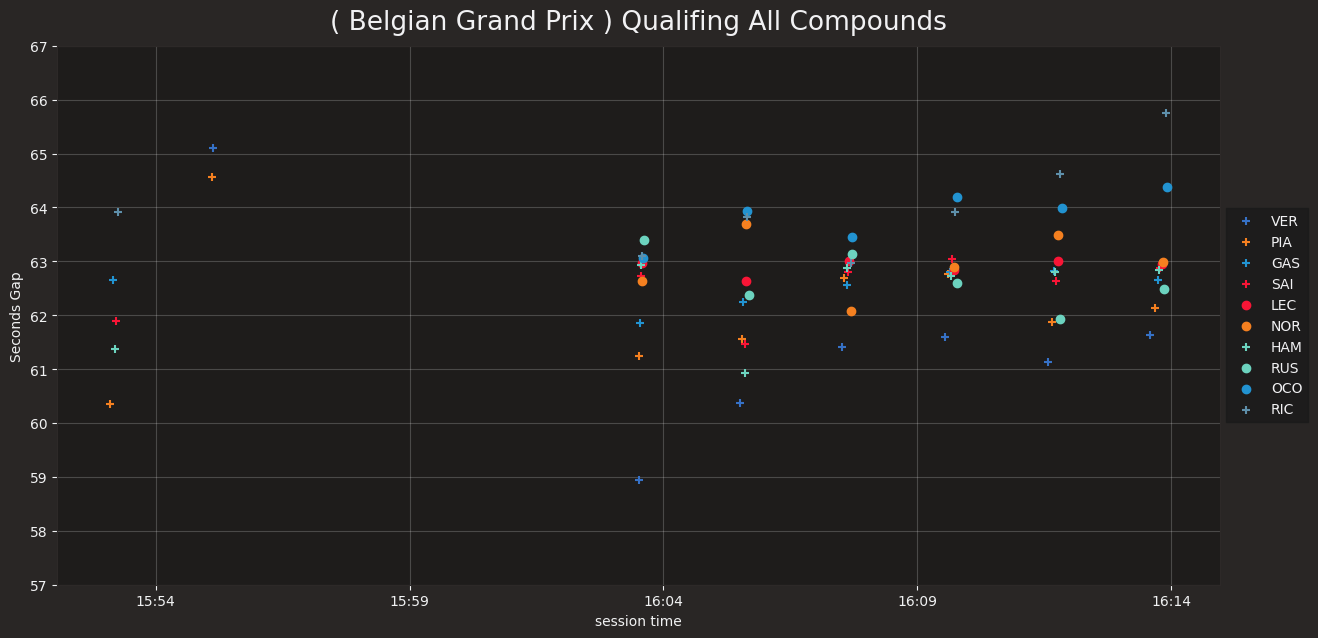

In [38]:
plt.figure(figsize=(15, 7))
color_picked = []
for i in drivers[:10]:
# for i in ['1','4','16','63']:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = session.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.scatter(x, y, color="#"+team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color="#"+team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('( '+session.event["EventName"]+' ) Qualifing' +" "+compound[comp])
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


### Qualifing standing 

In [39]:
team_color = []
# get data frame structure and delete the tuple 
fastest_lap = pd.DataFrame(laps.pick_driver(1).pick_fastest()).T.reset_index(drop=True)
fastest_lap = fastest_lap.drop(0)

# add fastest lap of every driver to df created before fastest_lap 
for i in drivers:
    fastlap = pd.DataFrame(laps.pick_driver(i).pick_fastest()).T.reset_index(drop=True)
    if (fastlap.isnull().all(axis=1).all()== False):
        fastest_lap = pd.concat([fastest_lap,fastlap ], ignore_index=True)
        team_color.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))
fastest_lap["LapTimeS"].fillna(0, inplace=True)
fastest_lap["TeamColor"] = team_color

c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2328: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  super().__init__(*args, **kwargs)


In [40]:
fastest_lap = fastest_lap.sort_values(by='LapTimeS').reset_index(drop=True)

In [41]:
# calculate gap to P1
fastest_lap["Gap"] = fastest_lap["LapTimeS"]-fastest_lap["LapTimeS"].min()

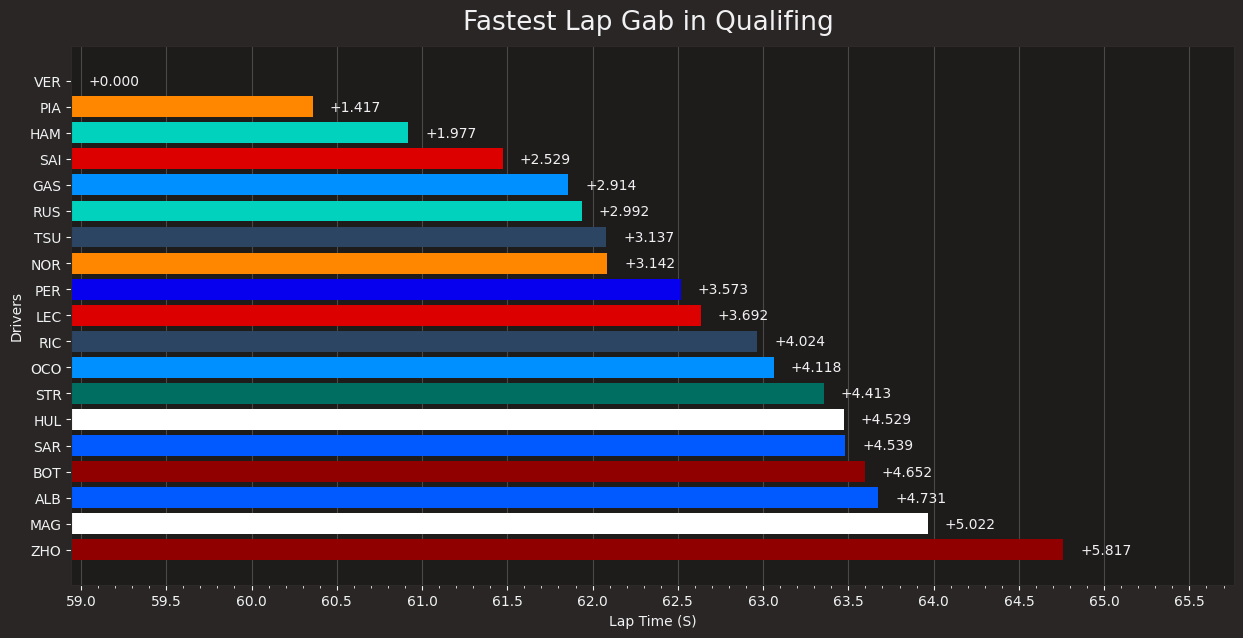

In [42]:
plt.figure(figsize=(15, 7))

y = fastest_lap["Driver"]
x = fastest_lap["LapTimeS"]
minx = fastest_lap["LapTimeS"].min()
maxx = fastest_lap["LapTimeS"].max()
# Create the horizontal bar plot
plt.barh(y,x , color = fastest_lap["TeamColor"])

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('Fastest Lap Gab in Qualifing ')
plt.xticks(range(80, 95, 1))
plt.xlim(minx, maxx+1)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(axis='x', alpha=0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    plt.text(fastest_lap["LapTimeS"][i] + 0.1, i, "+"+"{:.3f}".format(fastest_lap["Gap"][i]), va='center')

# Display the plot
plt.show()

In [43]:
table_results = fastest_lap[["Driver","Sector1Time","Sector2Time","Sector3Time","LapTime","Gap"]]

In [44]:
def highlight_min(s):
    is_min = s == s.min()
    return ['color: purple' if v else '' for v in is_min]

# Apply the styling using apply()
styled_df = table_results.style.apply(highlight_min, subset=['Sector1Time','Sector2Time','Sector3Time','LapTime'])
# Define the CSS styling for the header
header_styles = [
    {'selector': 'th',
     'props': [('background-color', 'purple'), ('color', 'white')]}
]

# Apply the header styling using set_table_styles()
# styled_df = table_results.style.set_table_styles(header_styles)
styled_df

,Driver,Sector1Time,Sector2Time,Sector3Time,LapTime,Gap
0,VER,0 days 00:00:33.167000,0 days 00:00:53.887000,0 days 00:00:31.889000,0 days 00:01:58.943000,0.000000
1,PIA,0 days 00:00:34.014000,0 days 00:00:54.189000,0 days 00:00:32.157000,0 days 00:02:00.360000,1.417000
2,HAM,0 days 00:00:32.879000,0 days 00:00:55.691000,0 days 00:00:32.350000,0 days 00:02:00.920000,1.977000
3,SAI,0 days 00:00:33.630000,0 days 00:00:55.969000,0 days 00:00:31.873000,0 days 00:02:01.472000,2.529000
4,GAS,0 days 00:00:33.228000,0 days 00:00:56.668000,0 days 00:00:31.961000,0 days 00:02:01.857000,2.914000
5,RUS,0 days 00:00:33.395000,0 days 00:00:56.555000,0 days 00:00:31.985000,0 days 00:02:01.935000,2.992000
6,TSU,0 days 00:00:33.337000,0 days 00:00:56.512000,0 days 00:00:32.231000,0 days 00:02:02.080000,3.137000
7,NOR,0 days 00:00:33.726000,0 days 00:00:56.135000,0 days 00:00:32.224000,0 days 00:02:02.085000,3.142000
8,PER,0 days 00:00:33.709000,0 days 00:00:56.531000,0 days 00:00:32.276000,0 days 00:02:02.516000,3.573000
9,LEC,0 days 00:00:33.036000,0 days 00:00:57.199000,0 days 00:00:32.400000,0 days 00:02:02.635000,3.692000
